In [1]:
pip install -Uqq fastai

Note: you may need to restart the kernel to use updated packages.


In [1]:
from fastai.vision.all import *


In [2]:
im=PILImage.create("/kaggle/input/new-nsys/images_final/row_1001_normal.png")
im.to_thumb(192)

In [4]:
path = Path('/kaggle/input/new-nsys/images_final')


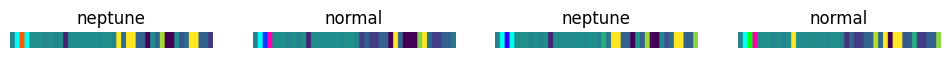

In [5]:
heatmaps = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda x: x.stem.split('_')[-1]  
)

dls = heatmaps.dataloaders(path,valid_pct=0.2)

# Display a batch of images
dls.valid.show_batch(max_n=4, nrows=1)


In [6]:
print(dls.vocab)


['back', 'ipsweep', 'neptune', 'nmap', 'normal', 'pod', 'portsweep', 'satan', 'smurf', 'teardrop', 'warezclient']


In [7]:
valid_items = dls.valid_ds.items


In [9]:
pip install -Uqq timm

Note: you may need to restart the kernel to use updated packages.


In [13]:
import timm
timm.list_models('beit*')

['beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224']

In [6]:

learn = cnn_learner(dls, 'beitv2_base_patch16_224', metrics=accuracy).to_fp16()
learn.fine_tune(10)


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,2.923913,1.666941,0.652648,00:19


epoch,train_loss,valid_loss,accuracy,time
0,2.211738,1.269653,0.682243,00:25
1,1.873794,1.303794,0.514019,00:26
2,1.624052,1.253964,0.510903,00:26
3,1.454598,0.954798,0.783489,00:25
4,1.285027,0.991038,0.761682,00:26
5,1.182608,0.997373,0.778816,00:26
6,1.101628,0.943188,0.742991,00:26
7,1.063347,0.965151,0.763240,00:26
8,1.030168,0.976145,0.708723,00:26
9,1.011092,0.944718,0.746106,00:26


In [ ]:
learn.export('heatmap_beitv2_1.pkl')


In [7]:

learn = cnn_learner(dls, 'convnext_base', metrics=error_rate).to_fp16()
learn.fine_tune(10)


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.850101,1.768958,0.300623,00:24


epoch,train_loss,valid_loss,error_rate,time
0,2.019055,1.570860,0.442368,00:30
1,1.832166,1.133549,0.241433,00:30
2,1.666754,1.034234,0.244548,00:30
3,1.477231,1.044367,0.236760,00:31
4,1.382136,1.009745,0.235202,00:31
5,1.274812,0.972293,0.252336,00:30
6,1.165341,0.962351,0.228972,00:30
7,1.114847,0.947346,0.228972,00:30
8,1.088592,0.943987,0.228972,00:30
9,1.066297,0.938170,0.228972,00:30


In [ ]:
learn.export('heatmap_convnext_base_1.pkl')


In [8]:

learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(5)


/usr/local/lib/python3.10/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [19]:

learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(3)


epoch,train_loss,valid_loss,accuracy,time
0,1.381842,0.737108,0.833333,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.361617,0.307341,0.928349,00:05
1,0.269630,0.136890,0.951713,00:05
2,0.200742,0.090349,0.968847,00:05


In [27]:

learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(5)


epoch,train_loss,valid_loss,accuracy,time
0,1.450687,0.709165,0.816199,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.319578,0.274283,0.951713,00:05
1,0.268408,0.158634,0.964174,00:04
2,0.210461,0.191514,0.954829,00:04
3,0.152758,0.096057,0.973520,00:04
4,0.110077,0.111092,0.981308,00:05


In [6]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
# Fine-tune the model
learn.fine_tune(5)


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,1.337438,0.205244,0.950156,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.181459,0.068142,0.982866,00:03
1,0.132283,0.088332,0.971963,00:02
2,0.097027,0.064629,0.984424,00:02
3,0.065827,0.058481,0.984424,00:02
4,0.053118,0.064388,0.985981,00:02


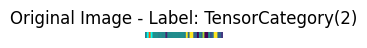

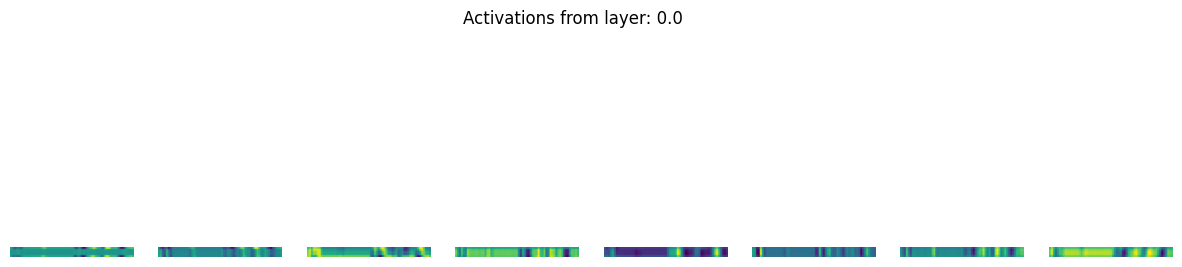

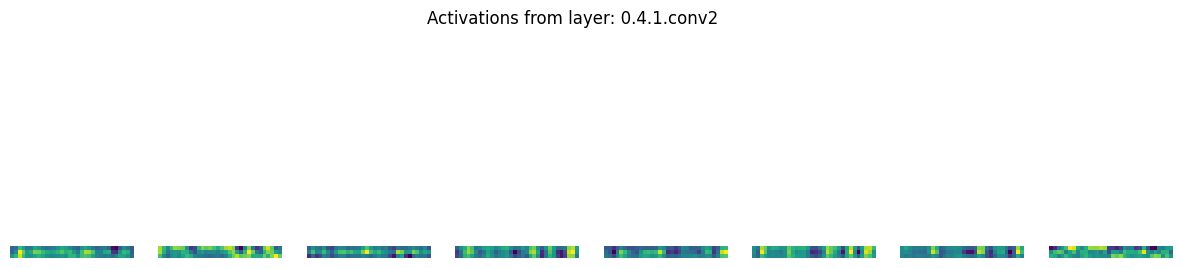

In [11]:

img, label = dls.valid_ds[0]
img.show(title=f"Original Image - Label: {label}")

model = learn.model

conv_layers = []
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        conv_layers.append((name, module))

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
handles = []
for name, module in conv_layers:
    handle = module.register_forward_hook(get_activation(name))
    handles.append(handle)

xb, = first(dls.test_dl([img]))
preds = model(xb)

for handle in handles:
    handle.remove()


def visualize_activations(activations, layer_name, num_filters=8):
    act = activations[layer_name].squeeze().cpu()
    num_filters = min(num_filters, act.shape[0])
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
    for i in range(num_filters):
        axes[i].imshow(act[i], cmap='viridis')
        axes[i].axis('off')
    plt.suptitle(f'Activations from layer: {layer_name}')
    plt.show()

visualize_activations(activations, conv_layers[0][0])


visualize_activations(activations, conv_layers[4][0])  


epoch,train_loss,valid_loss,accuracy,time
0,1.368231,0.197012,0.947040,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.189339,0.105580,0.965732,00:03
1,0.126944,0.099893,0.975078,00:03
2,0.094878,0.072678,0.981308,00:03
3,0.063349,0.073566,0.985981,00:03
4,0.048058,0.082746,0.976636,00:03


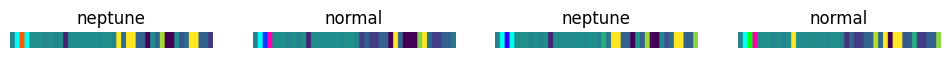

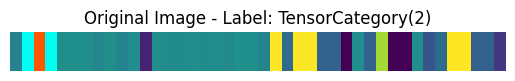

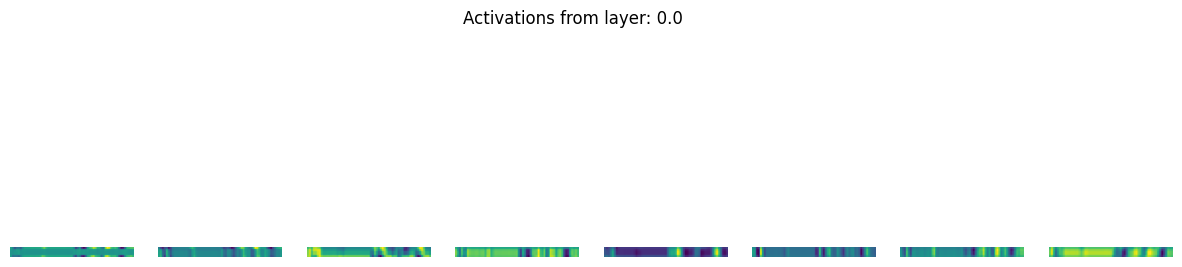

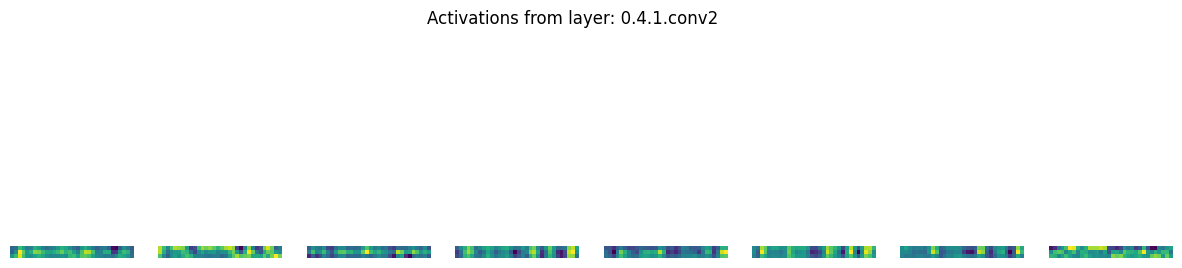

In [14]:
from fastai.vision.all import *
from fastai.callback.hook import *
import matplotlib.pyplot as plt

heatmaps = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda x: x.stem.split('_')[-1]  # Extracts 'normal' from 'row_1001_normal.png'
)

dls = heatmaps.dataloaders(path, valid_pct=0.2)

dls.valid.show_batch(max_n=4, nrows=1)

learn = cnn_learner(dls, resnet18, metrics=accuracy)

learn.fine_tune(5)


img, label = dls.valid_ds[0]

fig, ax = plt.subplots()
img.show(ctx=ax, title=f"Original Image - Label: {label}")
plt.savefig('original_image.png')
plt.show()
plt.close(fig)

model = learn.model

conv_layers = []
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        conv_layers.append((name, module))

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

handles = []
for name, module in conv_layers:
    handle = module.register_forward_hook(get_activation(name))
    handles.append(handle)

dl = dls.test_dl([img])
xb, = first(dl)
preds = model(xb)

for handle in handles:
    handle.remove()


# Function to visualize activations and save plots
def visualize_activations(activations, layer_name, num_filters=8):
    act = activations[layer_name].squeeze().cpu()
    num_filters = min(num_filters, act.shape[0])
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
    for i in range(num_filters):
        axes[i].imshow(act[i], cmap='viridis')
        axes[i].axis('off')
    plt.suptitle(f'Activations from layer: {layer_name}')
    plt.savefig(f"activations_{layer_name.replace('.', '_')}.png")  # Save the figure
    plt.show()
    plt.close(fig)  # Close the figure to free memory

visualize_activations(activations, conv_layers[0][0])


visualize_activations(activations, conv_layers[4][0])  


In [15]:
import os
import shutil

working_dir = '/kaggle/working'

# List all files and directories in the working directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  
            print(f"Deleted file: {file_path}")
        # If it is a directory, remove it and all its contents
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"Deleted directory: {file_path}")
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")


Deleted file: /kaggle/working/original_image.png
Deleted file: /kaggle/working/0.0_activations.png
Deleted file: /kaggle/working/activations_0_0.png
Deleted file: /kaggle/working/activations_0_4_1_conv2.png
Deleted file: /kaggle/working/0.4.1.conv2_activations.png
Deleted directory: /kaggle/working/.virtual_documents


epoch,train_loss,valid_loss,accuracy,time
0,1.335884,0.204801,0.945483,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.178428,0.069575,0.979751,00:02
1,0.138476,0.173024,0.954829,00:02
2,0.102098,0.070714,0.985981,00:02
3,0.068921,0.062405,0.982866,00:02
4,0.048829,0.066482,0.982866,00:02


Processing layer 1/20: 0.0
Processing layer 2/20: 0.4.0.conv1
Processing layer 3/20: 0.4.0.conv2
Processing layer 4/20: 0.4.1.conv1
Processing layer 5/20: 0.4.1.conv2
Processing layer 6/20: 0.5.0.conv1
Processing layer 7/20: 0.5.0.conv2
Processing layer 8/20: 0.5.0.downsample.0
Processing layer 9/20: 0.5.1.conv1
Processing layer 10/20: 0.5.1.conv2
Processing layer 11/20: 0.6.0.conv1
Processing layer 12/20: 0.6.0.conv2
Processing layer 13/20: 0.6.0.downsample.0
Processing layer 14/20: 0.6.1.conv1
Processing layer 15/20: 0.6.1.conv2
Processing layer 16/20: 0.7.0.conv1
Processing layer 17/20: 0.7.0.conv2
Processing layer 18/20: 0.7.0.downsample.0
Processing layer 19/20: 0.7.1.conv1
Processing layer 20/20: 0.7.1.conv2
All output plots have been zipped into activation_maps.zip


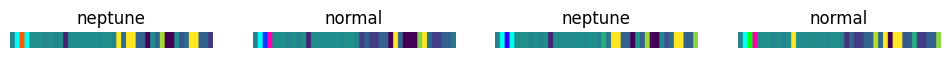

In [39]:
import os
import zipfile
from fastai.vision.all import *
from fastai.callback.hook import *
import matplotlib.pyplot as plt


heatmaps = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda x: x.stem.split('_')[-1]  # Extracts label from filename
)

# Create DataLoaders
dls = heatmaps.dataloaders(path, valid_pct=0.2)

# Display a batch of images
dls.valid.show_batch(max_n=4, nrows=1)

# Initialize the learner
learn = cnn_learner(dls, resnet18, metrics=accuracy)

# Fine-tune the model
learn.fine_tune(5)



# Get an image from the validation set
img, label = dls.valid_ds[0]

# Show and save the original image
fig, ax = plt.subplots()
img.show(ctx=ax, title=f"Original Image - Label: {label}")
plt.savefig('original_image.png')
plt.close(fig)

# Get the model
model = learn.model

# Define the layers we want to hook (e.g., Conv2d layers)
conv_layers = []
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        conv_layers.append((name, module))

# Create a dictionary to store activations
activations = {}

# Function to create a hook for each module
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for all convolutional layers
handles = []
for name, module in conv_layers:
    handle = module.register_forward_hook(get_activation(name))
    handles.append(handle)

# Pass the image through the model
# Convert the image into a batch with appropriate transforms
dl = dls.test_dl([img])
xb, = first(dl)
with torch.no_grad():
    preds = model(xb)

# Remove hooks
for handle in handles:
    handle.remove()

# Now, activations dict has the outputs from all Conv2d layers

# Function to visualize activations and save plots
def visualize_activations(activations, layer_name, num_filters=8):
    act = activations[layer_name].cpu()
    # Remove batch dimension if present
    if act.ndim == 4 and act.shape[0] == 1:
        act = act.squeeze(0)
    # Check if activations have 2D spatial dimensions
    if act.ndim != 3:
        print(f"Skipping layer {layer_name} with activation shape {act.shape}")
        return
    num_filters = min(num_filters, act.shape[0])
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
    for i in range(num_filters):
        activation = act[i]
        axes[i].imshow(activation, cmap='viridis')
        axes[i].axis('off')
    plt.suptitle(f'Activations from layer: {layer_name}')
    plt.savefig(f"activations_{layer_name.replace('.', '_')}.png")
    plt.close(fig)

# Visualize activations from all convolutional layers
for idx, (layer_name, _) in enumerate(conv_layers):
    print(f"Processing layer {idx+1}/{len(conv_layers)}: {layer_name}")
    visualize_activations(activations, layer_name)

# Code to zip all the output plots
# ---------------------------------

def zip_outputs(output_dir, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                if file.endswith('.png'):
                    zipf.write(os.path.join(root, file), arcname=file)
    print(f"All output plots have been zipped into {zip_filename}")

# Zip all the .png files in the current working directory
zip_outputs('/kaggle/working', 'activation_maps.zip')


In [40]:
from fastai.torch_basics import set_seed

set_seed(42)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(5,base_lr=1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.778082,0.292632,0.954829,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.196414,0.403549,0.926791,00:02
1,0.192379,0.145997,0.976636,00:02
2,0.152292,0.078162,0.982866,00:02
3,0.106360,0.048863,0.976636,00:02
4,0.070846,0.042149,0.987539,00:02


In [8]:
import torch
import numpy as np
import random
from fastai.torch_basics import set_seed

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set all seeds
set_all_seeds()

# Create the learner
learn = cnn_learner(dls, resnet18, metrics=accuracy)

# Fine-tune the model with a custom learning rate
learn.fine_tune(5, base_lr=1e-2)


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,0.719596,0.174808,0.959502,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.192706,0.148721,0.971963,00:02
1,0.211376,0.181162,0.967290,00:02
2,0.159396,0.063454,0.987539,00:03
3,0.100738,0.059508,0.979751,00:02
4,0.064011,0.045597,0.987539,00:02


In [41]:
import torch
import numpy as np
import random
from fastai.torch_basics import set_seed

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds()

learn = cnn_learner(dls, resnet18, metrics=accuracy)

learn.fine_tune(5, base_lr=1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.781251,0.181769,0.947040,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.200171,0.729721,0.928349,00:03
1,0.191025,0.120601,0.975078,00:02
2,0.153588,0.077972,0.971963,00:02
3,0.097038,0.068985,0.987539,00:02
4,0.065692,0.052663,0.985981,00:02


In [82]:
import torch
import numpy as np
import random
from fastai.torch_basics import set_seed

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds()

learn = cnn_learner(dls, resnet18, metrics=accuracy)

learn.fine_tune(5, base_lr=1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.741011,0.188985,0.967290,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.190883,0.147113,0.965732,00:03
1,0.155760,0.143811,0.975078,00:03
2,0.149971,0.070157,0.981308,00:03
3,0.108033,0.053352,0.987539,00:03
4,0.067960,0.046702,0.985981,00:03


In [14]:
import torch
import numpy as np
import random
from fastai.torch_basics import set_seed

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds()

learn = cnn_learner(dls, resnet18, metrics=accuracy)

learn.fine_tune(50)


epoch,train_loss,valid_loss,accuracy,time
0,1.313802,0.210003,0.940810,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.189703,0.087340,0.979751,00:03
1,0.120632,0.066748,0.984424,00:03
2,0.086421,0.055677,0.982866,00:03
3,0.065490,0.058654,0.982866,00:03
4,0.055089,0.072056,0.984424,00:03
5,0.051220,0.065044,0.984424,00:03
6,0.054503,0.070389,0.979751,00:03
7,0.044390,0.054730,0.987539,00:03
8,0.049867,0.054007,0.987539,00:03
9,0.052752,0.052380,0.984424,00:03


In [ ]:
import torch
import numpy as np
import random
from fastai.torch_basics import set_seed

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds()

learn = cnn_learner(dls, resnet34, metrics=accuracy)

learn.fine_tune(50)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 167MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,1.338816,0.308310,0.948598,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.242951,0.102505,0.971963,00:04
1,0.146894,0.080553,0.975078,00:03
2,0.099203,0.078821,0.981308,00:03
3,0.071037,0.074164,0.982866,00:03
4,0.059049,0.089851,0.982866,00:03
5,0.053704,0.114001,0.978193,00:03
6,0.055936,0.100042,0.981308,00:03
7,0.051924,0.105635,0.978193,00:03
8,0.067687,0.105005,0.987539,00:04
9,0.061957,0.065773,0.985981,00:03


In [16]:
interp = ClassificationInterpretation.from_learner(learn)

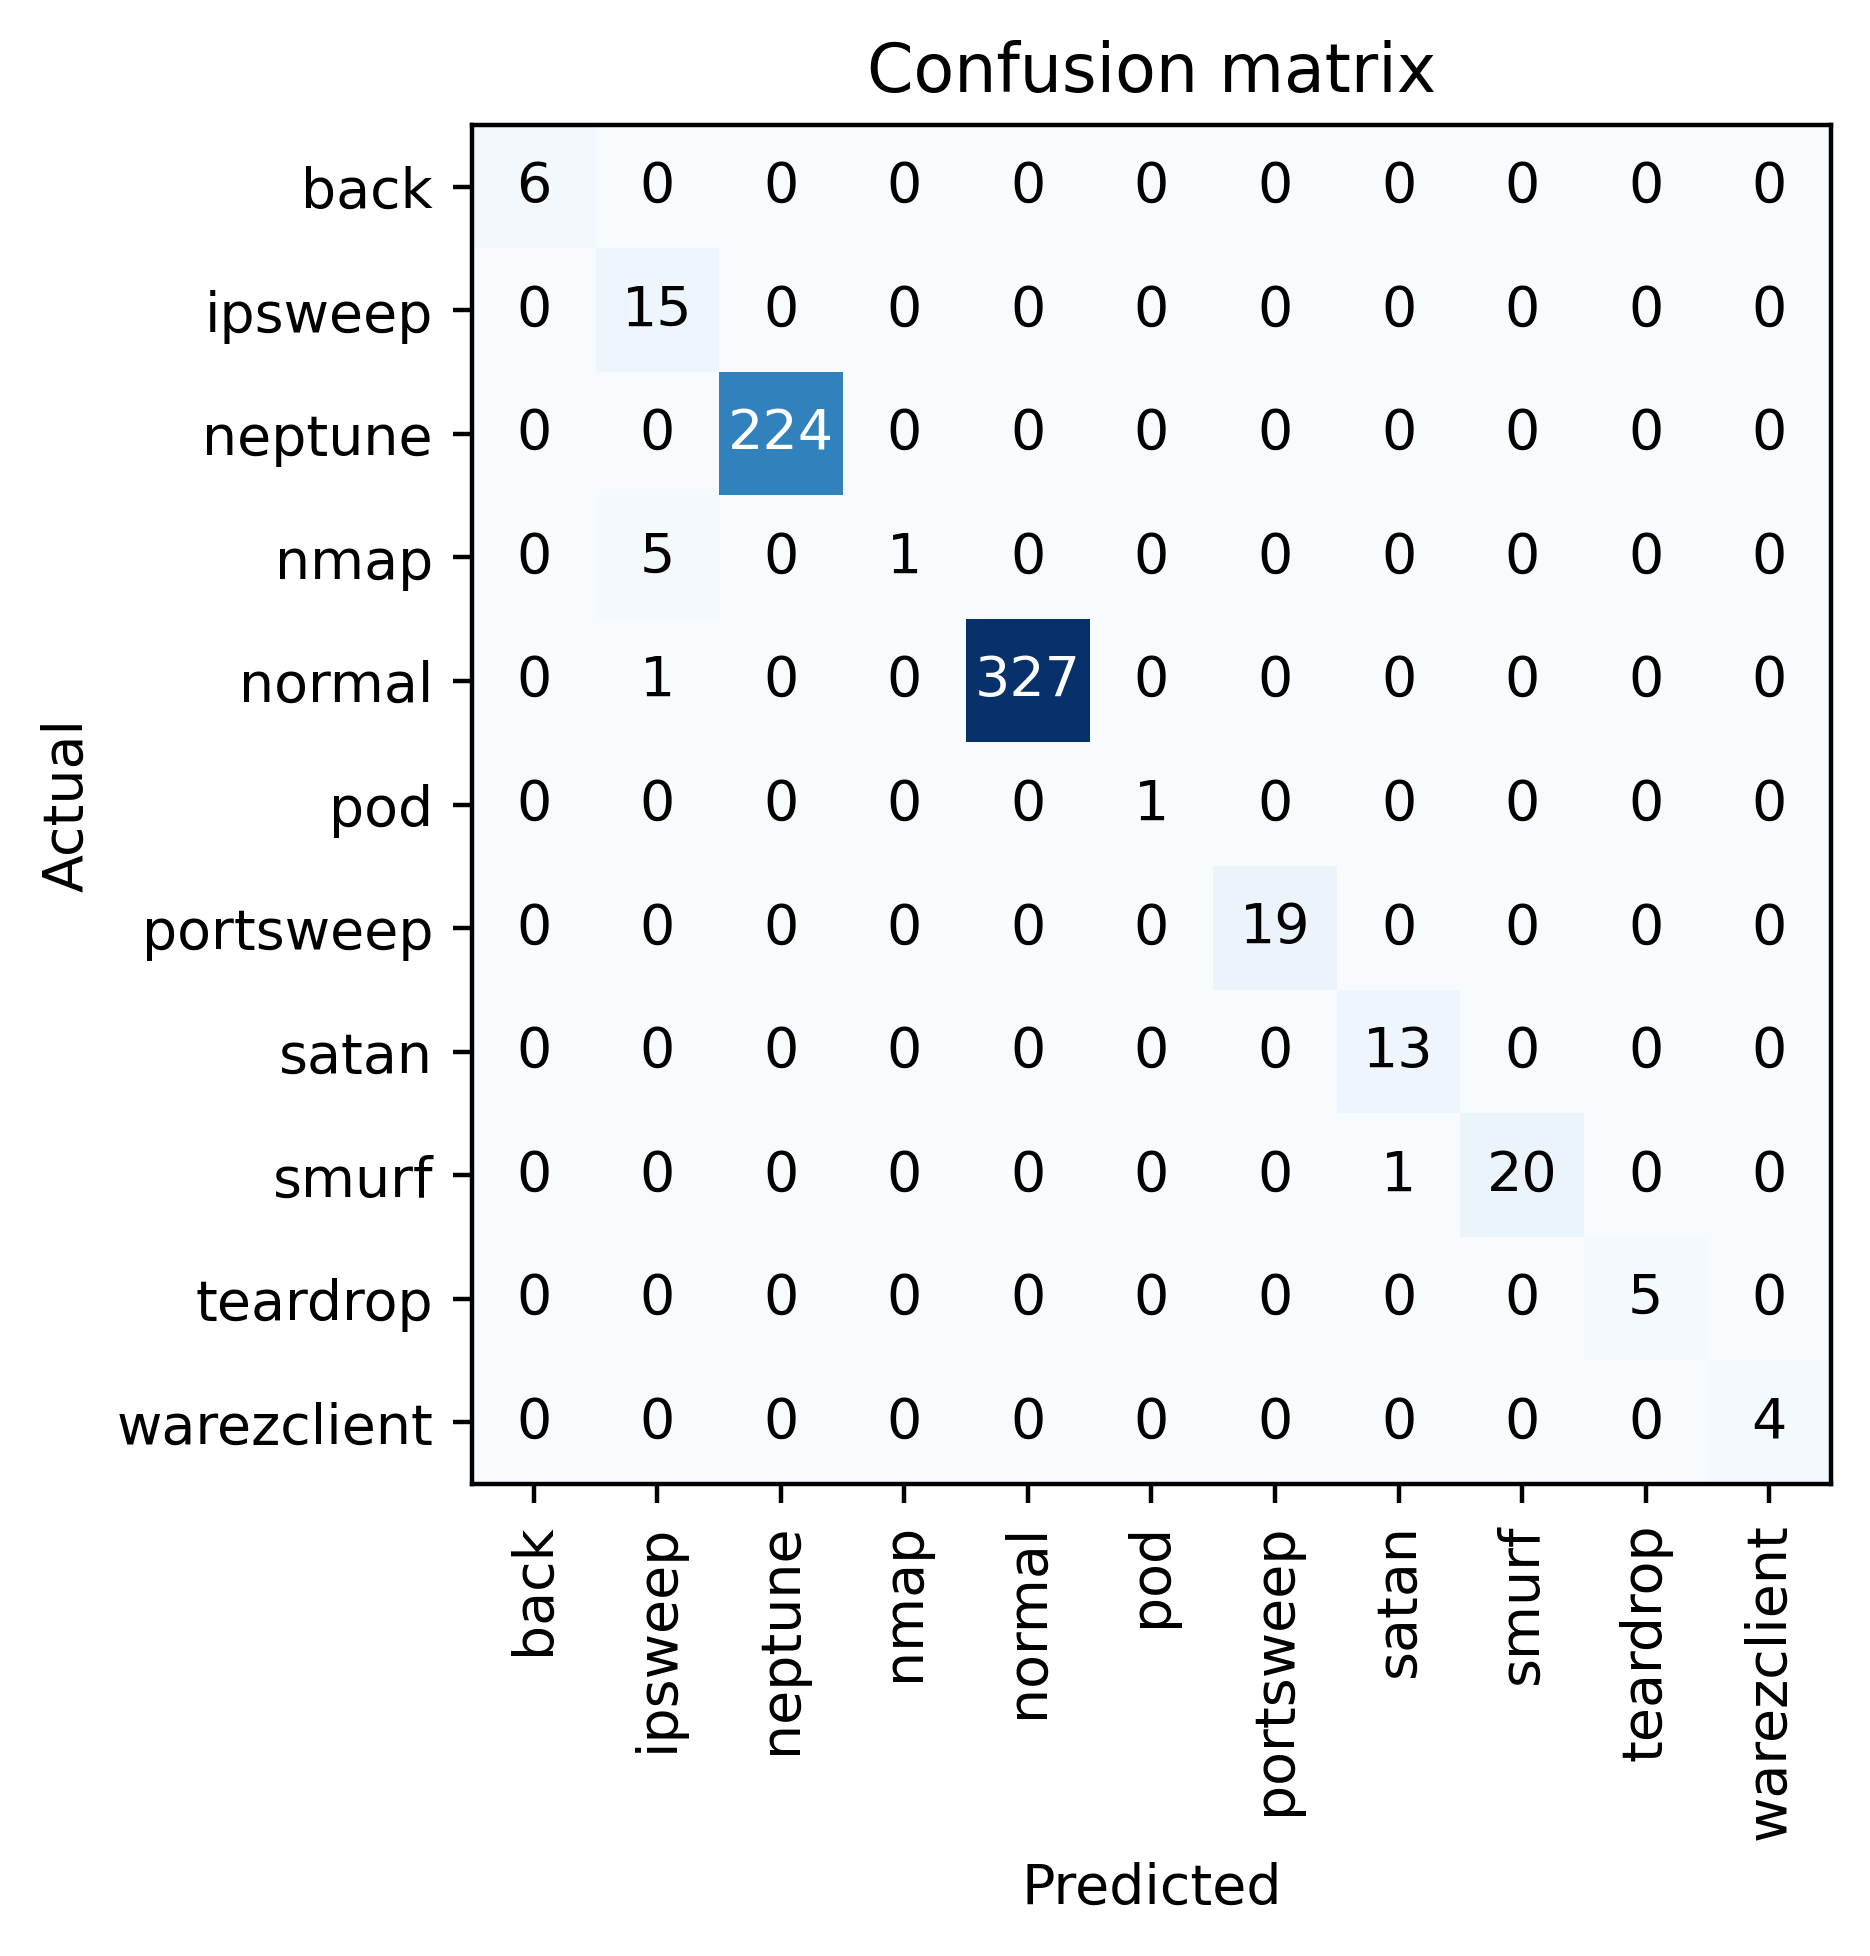

In [23]:
interp.plot_confusion_matrix( dpi=400)

plt.savefig('confusion_matrix2.png', dpi=400, bbox_inches='tight')


In [27]:
interp.most_confused()

[('nmap', 'ipsweep', 5), ('normal', 'ipsweep', 1), ('smurf', 'satan', 1)]

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

ValueError: not enough values to unpack (expected 2, got 1)

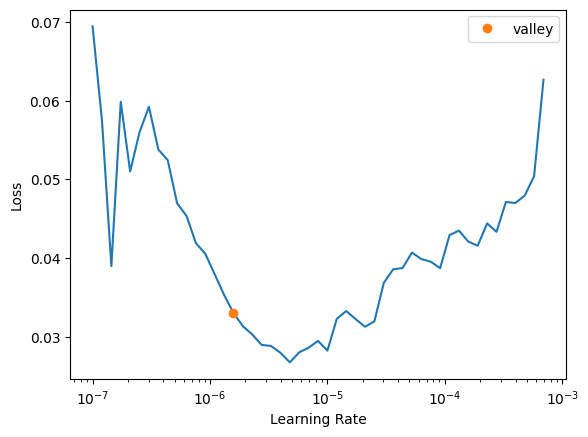

In [9]:
lr_min, lr_steep =learn.lr_find()



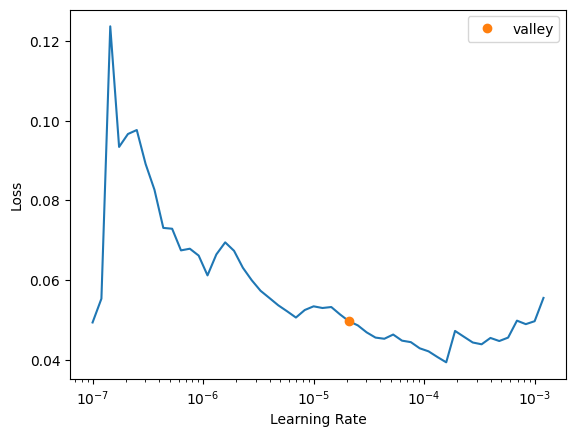

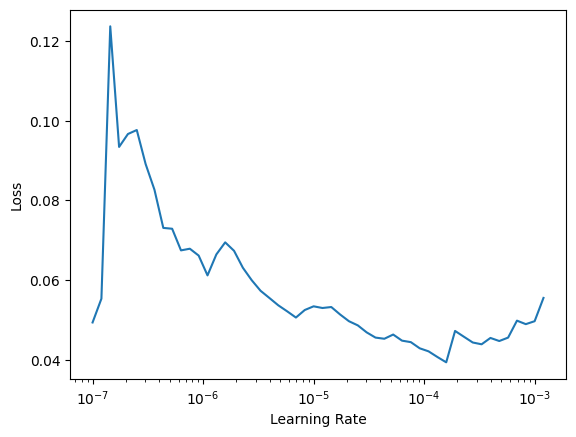

In [18]:
# Run learning rate finder
lr_finder = learn.lr_find()

# Plot the learning rate finder graph
learn.recorder.plot_lr_find()

# Save the plot with the specified parameters
import matplotlib.pyplot as plt

plt.savefig('lr_finder_plot.png', dpi=400, bbox_inches='tight')


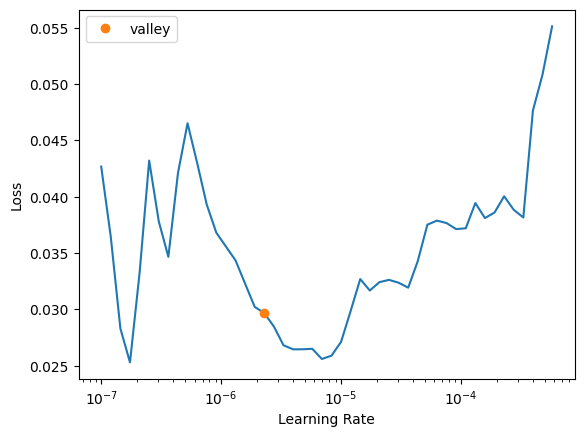

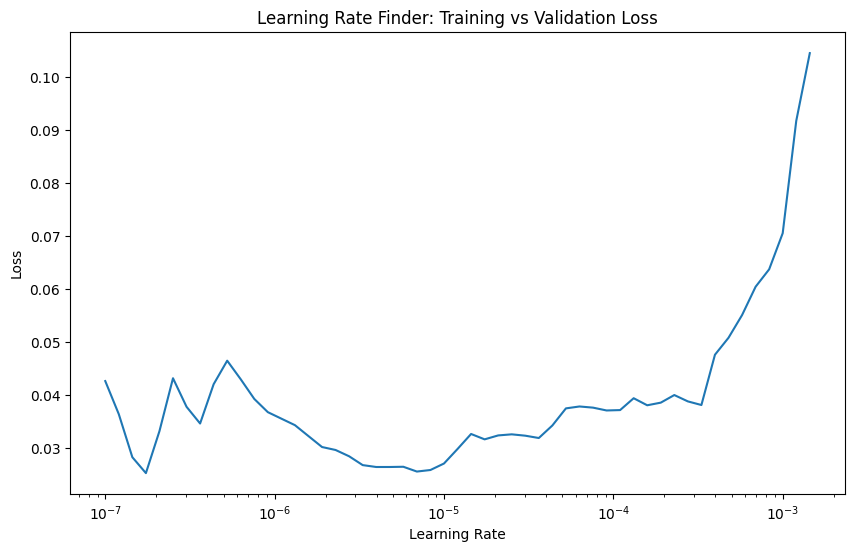

In [9]:
# Run learning rate finder
lr_finder = learn.lr_find()

# Extract the learning rates and training losses from the recorder
lrs = learn.recorder.lrs  # Learning rates
train_losses = learn.recorder.losses  # Training losses

# Plot the learning rate vs. training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lrs, train_losses, label='Training Loss')

# If validation losses are available, plot them as well
if hasattr(learn.recorder, 'val_losses') and learn.recorder.val_losses:
    val_losses = learn.recorder.val_losses
    plt.plot(lrs, val_losses, label='Validation Loss')

# Add labels and legend
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder: Training vs Validation Loss')

# Save the plot with the specified parameters
plt.savefig('lr_finder_plot.png', dpi=400, bbox_inches='tight')
plt.show()


/opt/conda/lib/python3.10/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

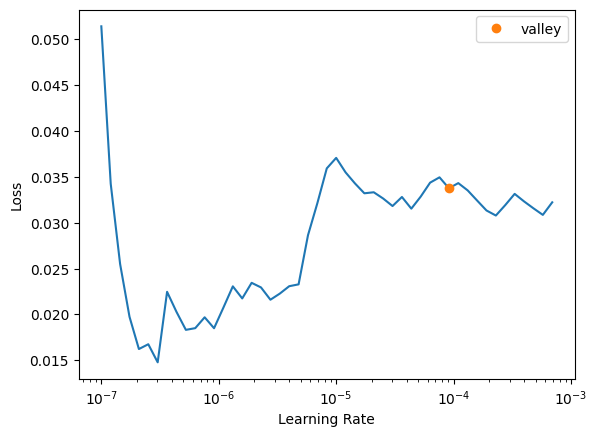

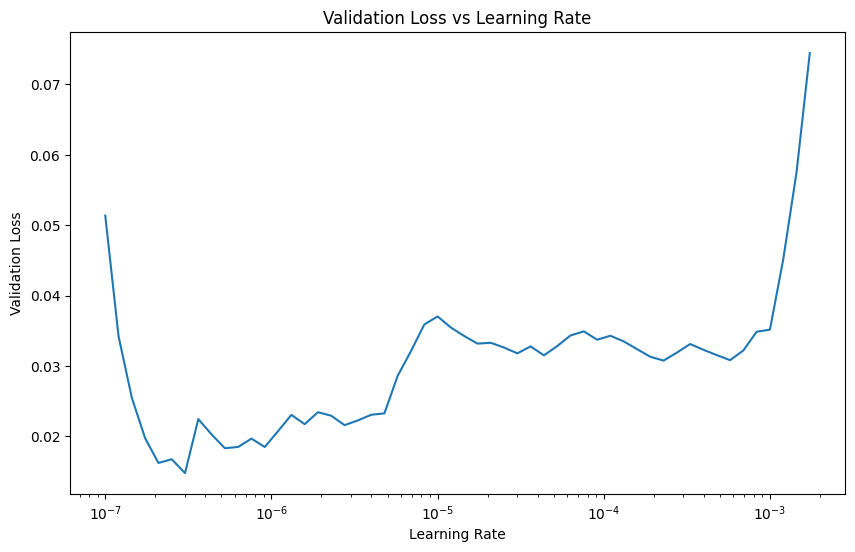

In [8]:
lr_finder = learn.lr_find()

lrs = learn.recorder.lrs  # Learning rates
train_losses = learn.recorder.losses  # Training losses

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lrs, train_losses, label='Training Loss')

if hasattr(learn.recorder, 'val_losses') and len(learn.recorder.val_losses) > 0:
    val_losses = learn.recorder.val_losses
    plt.plot(lrs, val_losses, label='Validation Loss')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Learning Rate')

plt.savefig('lr_finder_plot.png', dpi=400, bbox_inches='tight')

plt.show()


In [10]:
best_lr = lr_finder.valley
print(f"Best Learning Rate: {best_lr:.2e}")

Best Learning Rate: 2.29e-06


In [12]:
learn.fine_tune(100, base_lr=best_lr)


epoch,train_loss,valid_loss,accuracy,time
0,0.023103,0.059328,0.982866,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.027800,0.059677,0.985981,00:03
1,0.029724,0.058767,0.982866,00:03
2,0.032626,0.058977,0.984424,00:03
3,0.030817,0.056406,0.984424,00:03
4,0.026687,0.062476,0.982866,00:03
5,0.028072,0.058609,0.982866,00:03
6,0.028982,0.061004,0.982866,00:03
7,0.028513,0.057258,0.984424,00:03
8,0.027181,0.061673,0.981308,00:03
9,0.028193,0.058337,0.984424,00:03


KeyboardInterrupt: 

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

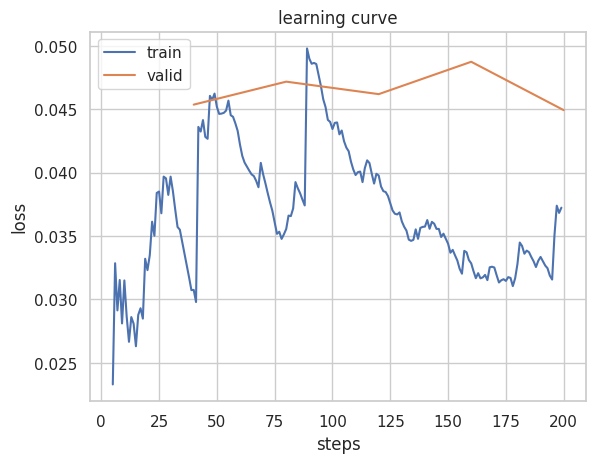

In [86]:
learn.recorder.plot_loss()


AUC curve saved as 'auc_curve.png'


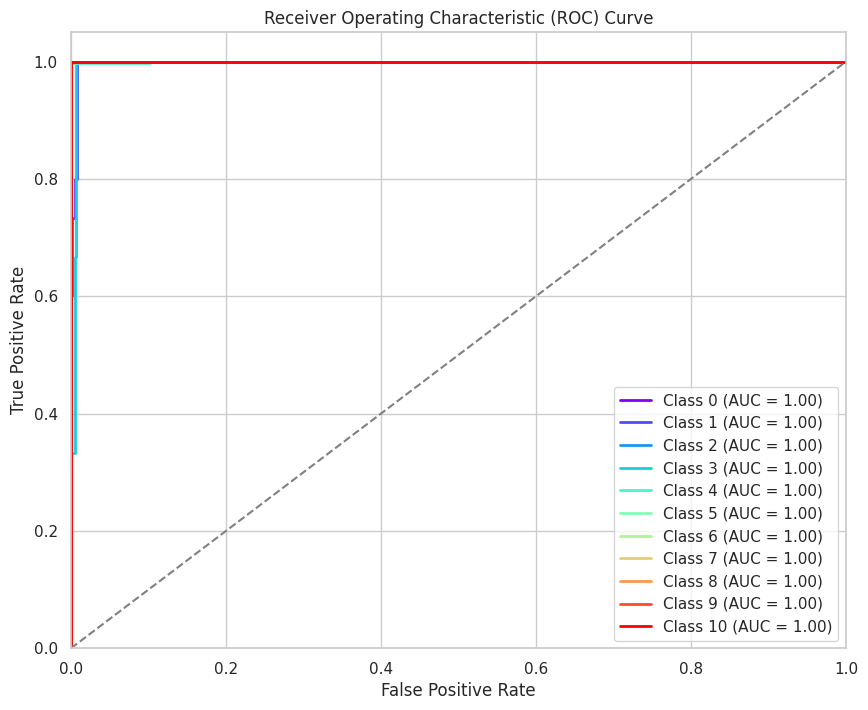

In [63]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Retrieve predictions and ground truth labels
preds, targets = learn.get_preds()
preds = preds.numpy()  # Convert to numpy arrays
targets = targets.numpy()

# Binarize the target labels
n_classes = preds.shape[1]  # Number of classes
targets_binarized = label_binarize(targets, classes=range(n_classes))
preds_binarized = preds

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(targets_binarized[:, i], preds_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save the plot as a PNG image
plt.savefig('auc_curve.png', dpi=400, bbox_inches='tight')

print("AUC curve saved as 'auc_curve.png'")


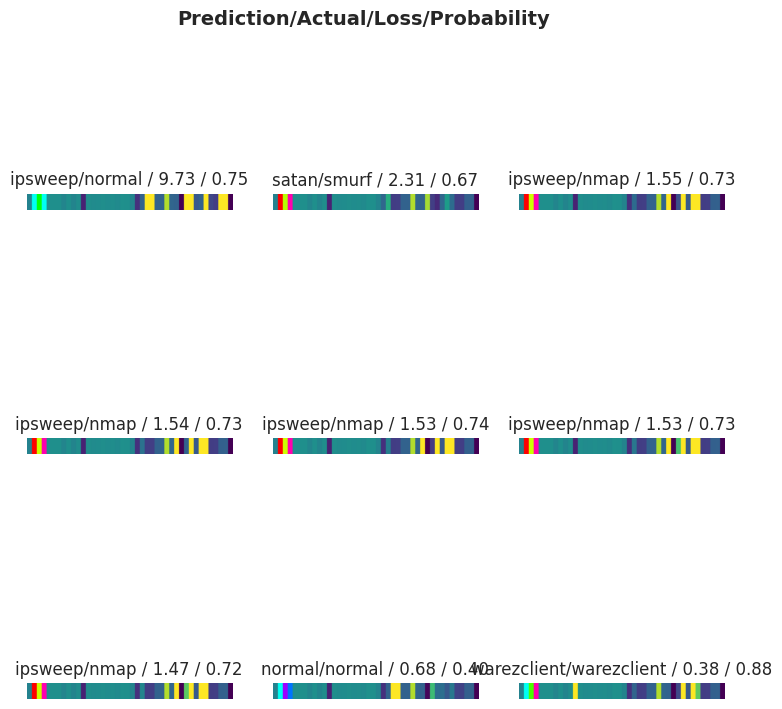

In [65]:

interp.plot_top_losses(9)

plt.savefig('top_losses.png', dpi=400, bbox_inches='tight')


In [67]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

preds, targs = interp.preds, interp.targs

for i in range(len(interp.vocab)):
    precision, recall, _ = precision_recall_curve(targs == i, preds[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {interp.vocab[i]}')
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.savefig('precision_recall_curve.png', dpi=400, bbox_inches='tight')
plt.show()


AttributeError: 'ClassificationInterpretation' object has no attribute 'preds'

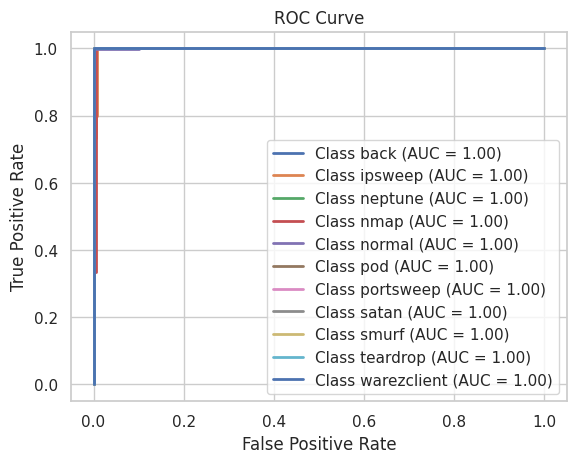

In [68]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = len(interp.vocab)
targs_bin = label_binarize(targs, classes=[i for i in range(n_classes)])

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(targs_bin[:, i], preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {interp.vocab[i]} (AUC = {roc_auc:.2f})')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.savefig('roc_curve.png', dpi=400, bbox_inches='tight')
plt.show()


Training logs saved as 'training_logs.png'


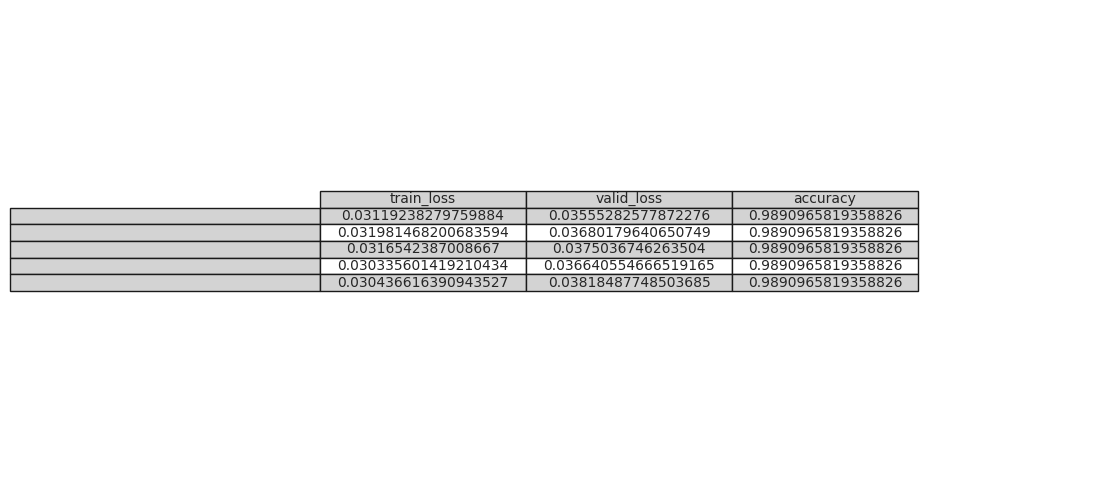

In [54]:
import torch
import numpy as np
import random
import pandas as pd

# Fine-tune the model with the best learning rate and capture the output
with learn.no_logging():  # Temporarily disable logging
    learn.fine_tune(5, base_lr=best_lr)

training_logs = pd.DataFrame(learn.recorder.values)
training_logs.columns = learn.recorder.metric_names[1:-1]  # Skip the first and last column names

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=training_logs.values,
                 colLabels=training_logs.columns,
                 cellLoc='center',
                 loc='center',
                 cellColours=[['lightgrey' if i % 2 == 0 else 'white' for _ in range(len(training_logs.columns))] for i in range(len(training_logs))],
                 rowColours=['lightgrey'] * len(training_logs),
                 colColours=['lightgrey'] * len(training_logs.columns))

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(range(len(training_logs.columns)))

plt.savefig('training_logs.png', dpi=400, bbox_inches='tight')

print("Training logs saved as 'training_logs.png'")


In [22]:

learn_resnet101 = cnn_learner(dls, resnet101, metrics=accuracy)
learn_resnet101.fine_tune(3)


epoch,train_loss,valid_loss,accuracy,time
0,1.480065,0.412324,0.895639,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.357913,0.153968,0.953271,00:08
1,0.321503,0.152114,0.965732,00:07
2,0.247118,0.092280,0.971963,00:07


In [23]:

learn_resnet152 = cnn_learner(dls, resnet152, metrics=accuracy)
learn_resnet152.fine_tune(3)


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 161MB/s]  


epoch,train_loss,valid_loss,accuracy,time
0,1.666342,0.593739,0.895639,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.454779,2.965513,0.942368,00:10
1,0.357715,1.002793,0.956386,00:11
2,0.260235,0.795144,0.956386,00:10


In [35]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(3, best_lr)

epoch,train_loss,valid_loss,error_rate,time
0,3.449769,1.852348,0.498442,00:03
1,2.671487,1.284651,0.317757,00:02
2,2.243428,1.171144,0.269470,00:03


In [72]:
learn.unfreeze()

SuggestedLRs(valley=0.0005754399462603033)

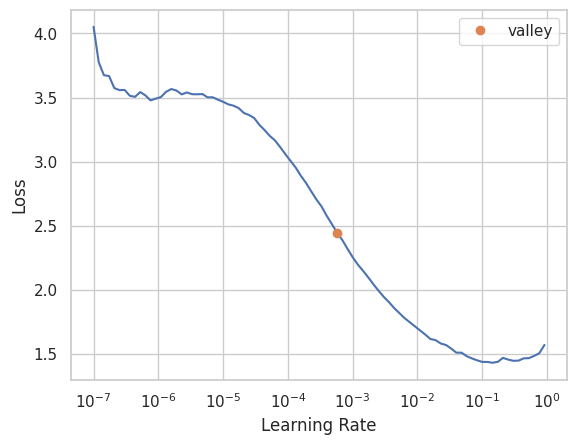

In [74]:
learn.lr_find()

In [77]:
learn.fit_one_cycle(6, lr_max=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,0.179427,0.284378,0.071651,00:03
1,1.050608,15.299155,0.303738,00:03
2,1.595214,1.699000,0.241433,00:03
3,1.168758,0.301269,0.076324,00:03
4,0.700211,0.142658,0.060748,00:04
5,0.444119,0.129056,0.037383,00:03


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

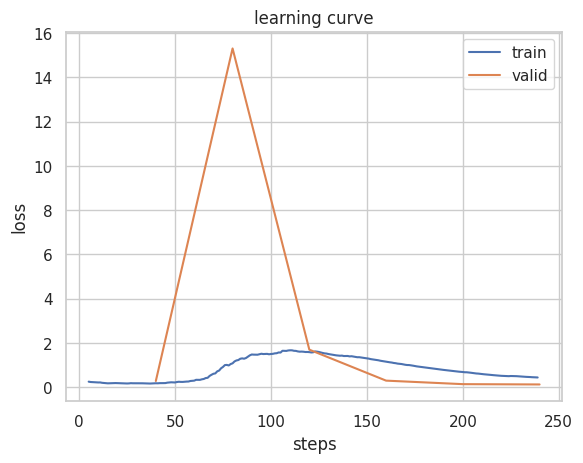

In [78]:
learn.recorder.plot_loss()

In [7]:

learn_densenet121 = cnn_learner(dls, densenet121, metrics=accuracy)
learn_densenet121.fine_tune(5)


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 145MB/s] 


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: Given input size: (256x1x16). Calculated output size: (256x0x8). Output size is too small

In [8]:

learn_efficientnet_b0 = cnn_learner(dls, efficientnet_b0, metrics=accuracy)
learn_efficientnet_b0.fine_tune(5)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 92.6MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.234418,0.312423,0.903427,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.341532,0.090232,0.961059,00:05
1,0.285677,0.069138,0.970405,00:04
2,0.219257,0.075255,0.968847,00:04
3,0.173206,0.066756,0.973520,00:04
4,0.172748,0.061628,0.975078,00:05
